# Machine Learning Complications

**Author:** Dr. Robert Lyon

**Contact:** robert.lyon@manchester.ac.uk

**Institution:** University of Manchester

**Affiliation:** SKA Group, Time Domain Team (TDT)

**Version:** 1.0

**Date: 30/08/2017**

**Acknowledgements:** This notebook utilises data obtained by the High Time Resolution Universe Collaboration using the Parkes Observatory, funded by the Commonwealth of Australia and managed by the CSIRO. The data was originally processed by Dr. Daniel Thornton & Dr. Samuel Bates, and I gratefully acknowledge their efforts.

## Introduction
This notebook explores the main issues which reduce the accuracy of Machine Learning (ML) algorithms, used for candidate classification. It was written to support a talk delivered at IAU Symposium No. 337, *Pulsar Astrophysics: The Next Fifty Years* (2017). The notebook covers three problems in particular:

* Violations of the Independent and Identically Distributed (i.i.d) assumption (see Bishop, 2006). This is fundamental to the success of all ML classifiers.
* Distributional drift occuring in survey data, which causes i.i.d violations (see Gama et. al. 2014) reducing classifier accuracy.
* The data pre-processing steps which cause i.i.d violations. This is especially problematic when trying to share data obtained during different surveys.

The notebook explores these problems through interactive Python code (Python version 2.7). The code requires the numpy, scipy, and scikit-learn libraries to function. The notebook assumes some basic background knowledge in statistics and machine learning (yet references to relevant work are provided).

## Code & License
The code and the contents of this notebook are released under the GNU GENERAL PUBLIC LICENSE, Version 3, 29 June 2007.

## Citation Request

We kindly request that if you make use of the notebook, please cite the work using the following bibtex source.

## Input Data

### Real Data
The input data consists of integrated pulse profiles, collected during the Medium Latitude portion of the High Time Resolution Universe Survey (HTRU) (see Thornton 2013 and Bates et. al. 2012). The data is comprised of $1,586$ pulsar and $8,852$ non-pulsar candidate profiles. Each profile contains exactly 128 phase bins. The data contains 725 of the known 1,108 pulsars (known at the time) in the Medium Latitude survey region (see Levin 2012), along with re-detections and harmonics. The data also contains noise examples, along with strong and weak forms of Radio Frequency Interference (RFI). This data is not to be confused with the [HTRU 2 feature data](https://dx.doi.org/10.6084/m9.figshare.3080389.v1) made available by Lyon et. al. (2016) - the feature data contains only machine learning features extracted from candidates, whilst this data set is made up of integrated pulse profiles only.

### Artificial Data
In some cases it is simpler to generate fake data, then to try and illustrate issues using real data. Where appropriate example data is generated using the random number generators provided by the numpy and scipy libraries. Where possible we stick to simple Gaussian distributions.

---

### Loading the Data

Here we simply load in the integrated pulse profile data, from files in the provided distribution. There are two files to be read in. The first contains integrated profiles for pulsars, the second contains noise and RFI profiles.

In [1]:
# Import the libraries to be used throughout.
%pylab inline
import matplotlib.pyplot as plt

# The HTRU 2 profile data is split - one file containing the real pulsar
# profiles, one file containing noise/interference profiles. We load both
# these data sources here. First we construct relative paths to the files.
data_dir = 'data/HTRU2'
pulsar_file = data_dir + '/HTRU2_pulsar.csv'
nonpulsar_file = data_dir + '/HTRU2_nonpulsar.csv'

# Now simply load the data.
pulsar_data = genfromtxt(pulsar_file, dtype=np.int,delimiter=',')
non_pulsar_data = genfromtxt(nonpulsar_file, dtype=np.int,delimiter=',')

# Print overview details.
print ('\n\nTotal number of pulsar profiles: ', len(pulsar_data))
print ('Total number of noise/RFI profiles: ', len(non_pulsar_data))

Populating the interactive namespace from numpy and matplotlib


Total number of pulsar profiles:  1586
Total number of noise/RFI profiles:  8852


Now we plot a single example of both classes, to show what the data looks like. First the pulsar example.

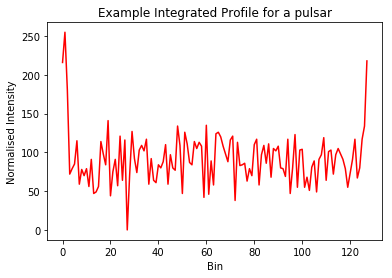

In [2]:
figure(1)
plot(pulsar_data[7], 'r')
xlabel('Bin')
ylabel('Normalised Intensity')
title('Example Integrated Profile for a pulsar')
show()

It is clear that the peak is not in the centre. For most examples it is, but not for all. How about for the non-pulsar examples?

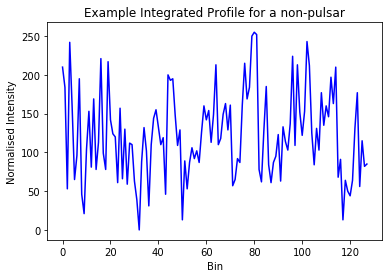

In [3]:
figure(2)
plot(non_pulsar_data[0], 'b')
xlabel('Bin')
ylabel('Normalised Intensity')
title('Example Integrated Profile for a non-pulsar')
show()

The non-pulsar example doesn't appear to be correctly centred either. So we centre the data using a simple function. We define this function below:

In [4]:
import operator

def centre_on_peak(data):
    """
    Centre the data such that the maximum y-axis value is in the
    centre of the data.

    Parameters
    ----------
    :param data: the data to be centred.

    Returns
    ----------
    :return: the centred data array.
    """
    # Stores the centred data.
    centred_data = []

    # Get the index of the maximum value.
    index, value = max(enumerate(data), key=operator.itemgetter(1))

    # Find midpoint of the data.
    midpoint = int(len(data)/2)

    # Figure out the shift required to centre the data (put max value in centre bin).
    n = midpoint - index  # N gives the number of bins the data should be shifted.
    a = n % len(data)

    # Apply the correction.
    centred_data = numpy.concatenate([data[-a:],data[:-a]])

    return centred_data

Now we execute this centering function.

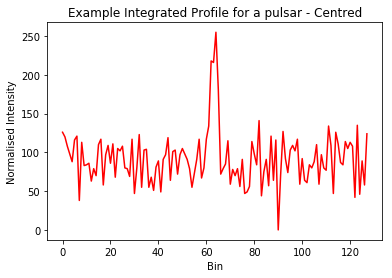

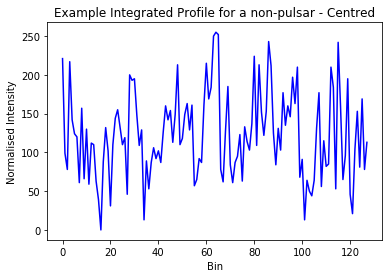

In [5]:
# Here we simply loop over each item in the data arrays,
# and update their values.
for i in range(0, len(pulsar_data)):
    pulsar_data[i] = centre_on_peak(pulsar_data[i])
    
for i in range(0, len(non_pulsar_data)):
    non_pulsar_data[i] = centre_on_peak(non_pulsar_data[i])
    
figure(3)
plot(pulsar_data[7], 'r')
xlabel('Bin')
ylabel('Normalised Intensity')
title('Example Integrated Profile for a pulsar - Centred')
show()

figure(4)
plot(non_pulsar_data[0], 'b')
xlabel('Bin')
ylabel('Normalised Intensity')
title('Example Integrated Profile for a non-pulsar - Centred')
show()

Now the data is correctly loaded and centred, we can move on.

---

## Importance of the i.i.d Assumption
Today students are subjected to many formal examinations throughout their time in education. To pass those exams, students must prepare, typically by studying the material to be covered in the exam. If the student works hard and learns the subject material, they'll likely do well. Machine learning algorithms are not much different. They are extremely studious when it comes to learning from the material they are given.

Occasionally an exam board and/or school makes a mistake when preparing for an exam. Sometimes students are given the wrong exam paper, other times they are taught the wrong subject material. The outcome is usually not good for anyone - especially for the students, as their performance will be limited. This outcome does not make them bad students. Rather, the circumstances they find themselves in are less than favourable. What we have described here via a simple analogy, is a violation of the i.i.d assumption. The i.i.d assumption implies that so long as the information used to train a machine learning classifier, is similar to the information it will be tested on, it will do well. Otherwise, it will likely perform poorly.

Much like for students, violations in the i.i.d assumption do not imply that a given learning algorithm is poor, or that the wrong algorithm was chosen for the job. We cannot know this, as we have simply given the algorithm the wrong information to learn from. Given the right information, the same algorithm could perform extremely well. It may even be the best algorithm for a particular problem. 

However, whereas it is easy to realise that students have been given the incorrect exam/subject material, it is much harder to know when we've poorly trained our algorithms. This is because differences between training data and real data can often be so subtle, that they are impossible to spot via a cursory analysis. Can you spot subtle distributional differences in an n-dimensional dataset - because I usually can't! To mitigate these issues we have to be diligent teachers. We have to be sure we are giving our algorithms the best chance to learn the concepts we're trying to teach them. This means we must understand our data first, to guard against fundamental i.i.d violations. When the i.i.d assumption is violated, no machine learning classifier can be expected to perform well.

There are three ways the i.i.d. assumption is commonly violated. These are explored in the sections that follow. Specifically, with reference to the pulsar candidate classification problem.

## When i.i.d is Violated

The i.i.d assumption holds when the feature data supplied in the training set, is independent from the feature data in the test set, yet identically distributed. The i.i.d assumption is violated when,

* The data used to train a classifier comes from a different source/data distribution, to the data the classifier will be applied to. For example, suppose a classifier is trained to recognise RFI using data collected at the Parkes telescope, but is deployed upon data obtained at the Green Bank Telescope.
* The data used to train and test a classifier, initially comes from the same source/data distribution. However over time, the distribution of the data being classified changes - either slowly, or abruptly. For example, the RFI environment surrounding most radio telescopes is subject to change over varying time-scales due to human activity. Any change causes a violation of the i.i.d. assumption. In the machine learning research literature, this problem is known more widely as distributional drift, or concept drift.
* The data used to train and test a classifier, initially comes from the same source/data distribution. However the data is post-processed in a different way to the data collected post-training. This could happen during a survey. For example, if a problem is spotted in the pre-processing, and a correction made which alters the data distributions.

These violations can easily occur, and perhaps unwittingly. We'll perform some experiments here that show how, in the following sections.

---

Next, we introduce some simple code used to extract the machine learning features we'll use in our experiments. These are the features which will be subjected to distributional change. The features are as follows:

* the mean
* the standard deviation
* the skew
* the excess kurtosis,

all extracted from the integrated pulse profile. These features were first presented in Lyon et. al. 2016, where they were subjected to a rigorous statistical analysis.

### Feature extraction code
The code provided below is optimised, so that it extracts the features in as few passes over the data as possible, whilst still giving accurate answers (not approximate answers).

In [6]:
def compute_features(data):
    """
    Computes machine learning feature values for the supplied data array.

    Parameters
    ----------
    :param data: a data array.

    Returns
    ----------
    :return: the computed machine learning features as a list [mean, stdev, shew, kurtosis].
    """
    if data is not None:  # Check data is not empty

        if len(data) > 0:

            # Sums computed during calculation.
            mean_sum = 0
            mean_subtracted_sum_power_2 = 0
            mean_subtracted_sum_power_3 = 0
            mean_subtracted_sum_power_4 = 0

            # The number of data points in the array.
            n = len(data)

            # Necessary first loop to calculate the sum, min and max
            for d in data:
                mean_sum += float(d)
            
            if mean_sum > 0 or mean_sum < 0:  # If the mean is less than or greater than zero (should be)
                
                # Update the mean value.
                mean_value = mean_sum / float(n)

                # Now try to compute the standard deviation, using
                # the mean computed above... we also compute values in
                # this loop required to compute the excess Kurtosis and
                # standard deviation.

                for d in data:
                    
                    mean_subtracted_sum_power_2 += np.power((float(d) - mean_value), 2.0)

                    # Used to compute skew
                    mean_subtracted_sum_power_3 += np.power((float(d) - mean_value), 3.0)

                    # Used to compute Kurtosis
                    mean_subtracted_sum_power_4 += np.power((float(d) - mean_value), 4.0)

                # Update the standard deviation value.
                stdev = np.sqrt(mean_subtracted_sum_power_2 / (n - 1.0))
                # Next try to calculate the excess Kurtosis and skew using the
                # information gathered above.

                one_over_n = 1.0 / n  # Used multiple times...

                kurt = ((one_over_n * mean_subtracted_sum_power_4) / np.power((one_over_n * mean_subtracted_sum_power_2), 2) ) - 3

                skew = (one_over_n * mean_subtracted_sum_power_3) / np.power(np.sqrt(one_over_n * mean_subtracted_sum_power_2), 3)
                    
                return [mean_value, stdev, skew, kurt]
                
            else:  # Data sums to zero, i.e. no data!
                return [0,0,0,0]
            
        else:  # Data empty for some reason...
            return [0,0,0,0]

It's clear that the function is producing values very close to those expected from the theory. It is also clear that our function is giving the same answers to the numpy function. So it appears to be working well. Now for another test, this time on the uniform distribution.

## The Impacts of i.i.d Violations

We now provide three examples to show why we must guard against violations of the i.i.d assumption. 

### Different Training & Test Distributions
This experiment shows how classifier performance degrades when data distributions change, causing violations in the i.i.d. assumption. To illustrate just how bad the effects can be, we do not use real data here. Instead, we use some idealised (and simple) Gaussian distribution data. The approach is as follows:

1. Generate a collection of 1000 target class examples, comprised of exactly 3 features each. Here the 'target' class simply means the class we consider most important, i.e. the positive class. For simplicity, we assume each of our three features is normally distributed.
2. To create the features which comprise the target class examples, we create normally distributed artificial feature vectors $f^{1}$, $f^{2}$, and $f^{3}$. All three vectors have a $\mu=0$ and $\sigma=1.0$. We use the numpy random number generator to populate these vectors. 
3. To create each example $x_{i}$, we simply assign it the values at position $i$, in each of the feature vectors. Thus each $x_{i} = \lbrace f^{1}_{i}, f^{2}_{i}, f^{3}_{i} \rbrace $.
4. We add the newly created examples to a set, $X$.
5. We assign a label $y_{i}$ to each $x_{i}$. We do this by adding labels to the column vector $Y$. It contains the true class label for each $x_{i}$.
6. Repeat steps 1 to 5, but for the creation of 1000 non-target class examples. For these $f^{1}$ has a $\mu=0.1$ and $\sigma=2.0$, $f^{2}$ has a $\mu=0.2$ and $\sigma=2.5$, and $f^{3}$ has a $\mu=0.3$ and $\sigma=3.0$.


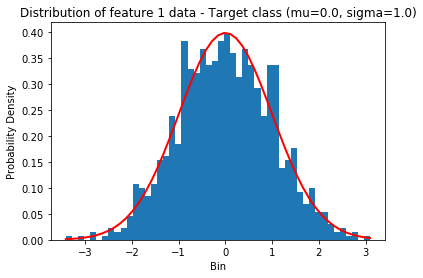

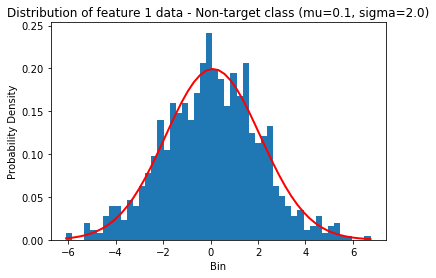

In [7]:
# Import the random library again, just incase
# this notebook is executed out of order.
import random as rnd

# Set a simple seed value - ensures the results
# are reproducible.
np.random.seed(12345678)

X = [] # Stores the feature data.
Y = [] # Stores the class labels.

# Generate the feature data for the target class examples.
f1 = np.random.normal(0, 1.0, 1000)
f2 = np.random.normal(0, 1.0, 1000)
f3 = np.random.normal(0, 1.0, 1000)

# Now show how the data looks...
figure(5)
count, bins, ignored = hist(f1, 50, normed=True)

# Since we now what the mu and sigma values are, we
# plot a theoretical curve. We can then compare the
# distribution to this curve.
mu = 0.0
sigma = 1.0

# Plot theoretical curve
plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
ylabel('Probability Density')
xlabel('Bin')
title('Distribution of feature 1 data - Target class (mu=0.0, sigma=1.0)')
show()

# Now store the feature values and labels, in the correct
# sets. Remember X contains the feature data, Y the true
# class labels. Here the true class label is always 1, as
# this data represents the target class.
for x, y, z in zip(f1, f2, f3):
    X.append([x,y,z])
    Y.append(1)

# Now generate the non-target data.
f1 = np.random.normal(0.1, 2.0, 1000)
f2 = np.random.normal(0.2, 2.5, 1000)
f3 = np.random.normal(0.3, 3.0, 1000)

for x, y, z in zip(f1, f2, f3):
    X.append([x,y,z])
    Y.append(0)

# Now show how the data looks...
figure(6)
count, bins, ignored = hist(f1, 50, normed=True)

# Since we now what the mu and sigma values are, we
# plot a theoretical curve. We can then compare the
# distribution to this curve.
mu = 0.1
sigma = 2.0

# Plot theoretical curve
plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
ylabel('Probability Density')
xlabel('Bin')
title('Distribution of feature 1 data - Non-target class (mu=0.1, sigma=2.0)')
show()
    
# Some cleanup
f1 = None
f2 = None
f3 = None
mu = None
sigma = None

The data looks good, so we can continue. Next we split the data into test and training samples. This is important so we can build and test a machine learning classifier on the data. To do this, we use functions built in to the scikit-learn machine learning library.

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)

print ('Examples in training set: ' , str(len(x_train)))
print ('Examples in testing set: ' , str(len(x_test)))

Examples in training set:  1000
Examples in testing set:  1000


Now that we have generated some example data, lets see what happens when we build a classifier to operate on this data. We will use a simple Bayesian classifier for this data.

In [9]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()

# First train the classifier with call to fit.
classifier.fit(x_train, y_train)

# Now obtain the classifiers 'score'
accuracy = classifier.score(x_test, y_test)
print ("Naive Bayes Classifier accuracy: ", (100* accuracy), "%.")

Naive Bayes Classifier accuracy:  85.2 %.


Now lets see what happens as the data distributions diverge, causing i.i.d violations. Here we shift the target class distributions only, in some new test data. In particular we change only the mean of the target class feature distributions in this data. This code can take around 30 seconds to execute.

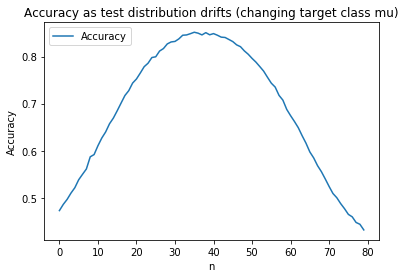

In [10]:
# Store the accuracy recorded for each 
# distributional change.
recorded_accuracies = []

# Some simple displacements we'll apply
# to the feature distributions the classifier
# was trained upon.
displacements = np.arange(-2.0,2.0,0.05)

# Stores the non-i.i.d used during this experiment.
x_test_non_iid = []
y_test_non_iid = []

# For each displacement
for d in displacements:
    
    # Used to compute classifier accuracy after each run.
    aggregate_sum = 0.0
    aggregate_accuracy = 0.0
    
    n = 25
    # For n iterations...
    for x in np.arange(0,n,1.0):
        
        x_test_non_iid = []
        y_test_non_iid = []
        
        # Generate some new example data using the 
        # displacement values to move the feature distributions.
        f1 = np.random.normal(0.1+d, 1.0, 1000)
        f2 = np.random.normal(0.1+d, 1.0, 1000)
        f3 = np.random.normal(0.1+d, 1.0, 1000)

        for x, y, z in zip(f1, f2, f3):
            x_test_non_iid.append([x,y,z])
            y_test_non_iid.append(1)
        
        # Now generate the non-target data.
        f1 = np.random.normal(0.1, 2.0, 1000)
        f2 = np.random.normal(0.2, 2.5, 1000)
        f3 = np.random.normal(0.3, 3.0, 1000)

        #noise_1 = np.random.normal(0.4+d, 2.0, 1000)
        #noise_2 = np.random.normal(0.5+d, 2.5, 1000)
        #noise_3 = np.random.normal(0.6+d, 3.0, 1000)

        for x, y, z in zip(f1, f2, f3):
            x_test_non_iid.append([x,y,z])
            y_test_non_iid.append(0)

        accuracy = classifier.score(x_test_non_iid, y_test_non_iid)
        aggregate_sum += accuracy

    #print "NB accuracy: ", accuracy # Uncomment if you wish to see the values
    recorded_accuracies.append(aggregate_sum/float(n))

# Some cleanup
f1 = None
f2 = None
f3 = None
x_test_non_iid = None
y_test_non_iid = None

# Now plot the change observed in classifier accuracy over time.
plt.plot(recorded_accuracies,label='Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('n')
plt.title('Accuracy as test distribution drifts (changing target class mu)')
plt.legend(loc='upper left')
plt.show()

The plot above shows how a change in the mean of the target class feature distributions (for $f^{1}_{i}, f^{2}_{i}, f^{3}_{i}$), alters classification performance. Performance can drop below 50%, which is no better then random guessing! This is clearly not good. But what happens if both classes experience change in their feature distributions? Suppose the non-target class now experiences change in $\sigma$ in a new independent sample.

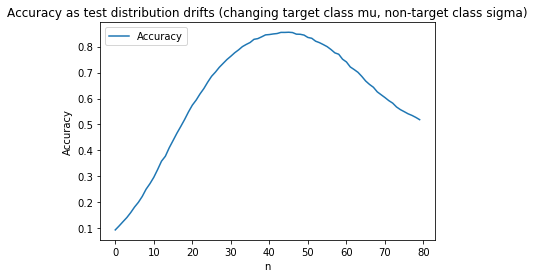

In [11]:
# Store the accuracy recorded for each 
# distributional change.
recorded_accuracies = []

# Some simple displacements we'll apply
# to the feature distributions the classifier
# was trained upon.
displacements = np.arange(-2.0,2.0,0.05)

# Stores the non-i.i.d used during this experiment.
x_test_non_iid = []
y_test_non_iid = []

# For each displacement
for d in displacements:
    
    # Used to compute classifier accuracy after each run.
    aggregate_sum = 0.0
    aggregate_accuracy = 0.0
    
    n = 25
    # For n iterations...
    for x in np.arange(0,n,1.0):
        
        x_test_non_iid = []
        y_test_non_iid = []
        
        # Generate some new example data using the 
        # displacement values to move the feature distributions.
        f1 = np.random.normal(0.1+d, 1.0, 1000)
        f2 = np.random.normal(0.1+d, 1.0, 1000)
        f3 = np.random.normal(0.1+d, 1.0, 1000)

        for x, y, z in zip(f1, f2, f3):
            x_test_non_iid.append([x,y,z])
            y_test_non_iid.append(1)
        
        # Now generate the non-target data.
        f1 = np.random.normal(0.1, 2.0+d, 1000)
        f2 = np.random.normal(0.2, 2.5+d, 1000)
        f3 = np.random.normal(0.3, 3.0+d, 1000)

        for x, y, z in zip(f1, f2, f3):
            x_test_non_iid.append([x,y,z])
            y_test_non_iid.append(0)

        accuracy = classifier.score(x_test_non_iid, y_test_non_iid)
        aggregate_sum += accuracy

    #print "NB accuracy: ", accuracy # Uncomment if you wish to see the values
    recorded_accuracies.append(aggregate_sum/float(n))

# Some cleanup
f1 = None
f2 = None
f3 = None
x_test_non_iid = None
y_test_non_iid = None

# Now plot the change observed in classifier accuracy over time.
plt.plot(recorded_accuracies,label='Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('n')
plt.title('Accuracy as test distribution drifts (changing target class mu, non-target class sigma)')
plt.legend(loc='upper left')
plt.show()

As you can see, the result is even more stark, with accuracy being heavily impacted as the i.i.d assumption is violated. So you may wonder is this really a significant problem? Whilst what we have shown here is somewhat contrived, the effects are real. The i.i.d assumption is often violated in real-world problems.

This example shows the impact of using training examples with a different distribution to real-world data. For example, when using data obtained at one telescope to train a classifier which will be applied to data collected by another. It also shows the impact on classification performance when real-world data changing over time. This is especially relevant for astronomers, where local RFI environments often change. 

### Same Data Distribution Different Pre-processing
Data collected at the same telescope can still result in i.i.d violations, if it has been pre-processed in different ways. Here we use the example profile data loaded earlier, to show how this can happen. The example data is scaled to the range [0,255]. Suppose a classifier is trained on features extracted this information. Lets use the 4 features defined earlier (mean, standard deviation, skew and excess kurtosis). 

Suppose the same trained classifier is then asked to classify profiles from the *same* distribution, but which are described in the range [0,1]. The features extracted from this second set of profiles, are now computed over a completely different data range. What's the impact on classification performance?

First we define the function we'll use to rescale our data:

In [12]:
def scale(data,new_min, new_max):
    """
    Scales data to within the range [new_min,new_max].

    Parameters
    ----------
    :param data: the data to scale.
    :param new_min: the new minimum value for the data range.
    :param new_max: the new maximum value for the data range.

    Returns
    ----------
    :return: A new array with the data scaled to within the range [new_min,new_max].
    """
    min_ = min(data)
    max_ = max(data)

    new_data = []

    for n in range(len(data)):

        value = data[n]
        x = (new_min * (1-( (value-min_) /( max_- min_ )))) + (new_max * ( (value-min_) /( max_- min_ ) ))
        new_data.append(x)

    return new_data

Next we observe the performance when the data isn't scaled differently. The following cell takes approximately 20-30 seconds to execute.

In [13]:
# Now scale the first half of each data set to [0,1],
# and add to the test and training data sets.
from sklearn.model_selection import train_test_split
    
X = [] # Stores the feature data.
Y = [] # Stores the class labels.

# Add pulsar examples.
for i in range(0, len(pulsar_data)):
    
    # Now here we extract the features with the call
    # to compute_features().
    X.append(compute_features(pulsar_data[i]))
    Y.append(1)

# Add non-pulsar examples.
for i in range(0, len(non_pulsar_data)):
             
    # Now here we extract the features with the call
    # to compute_features().
    X.append(compute_features(non_pulsar_data[i]))
    Y.append(0)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)

print ('\nExamples in training set: ' , str(len(x_train)))
print ('Examples in testing set: ' , str(len(x_test)))
             
# There should be 4 features per example. Lets just check this is
# the case.
print ('Dimensions of training set: ' , str(np.asarray(x_train).shape))
print ('Dimensions of testing set: ' , str(np.asarray(x_test).shape))


Examples in training set:  5219
Examples in testing set:  5219
Dimensions of training set:  (5219, 4)
Dimensions of testing set:  (5219, 4)


Now we build and test the classifier.

In [14]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()

# First train the classifier with call to fit.
classifier.fit(x_train, y_train)

# Now obtain the classifiers 'score'
accuracy = classifier.score(x_test, y_test)
print ("Naive Bayes Classifier accuracy: ", (100* accuracy), "%.")

Naive Bayes Classifier accuracy:  95.9379191416 %.


We can see that when the data belongs to the same distribution/data ranges, even a simple classifier can do well using only 4 features.  Now we use the scale function to convert some of the data into different data ranges. We then re-run this experiment.

In [15]:
# Get fresh data sets to prevent making mistakes
# Also keeps the cells modular.

X = [] # Stores the feature data.
Y = [] # Stores the class labels.

# Add pulsar examples.
for i in range(0, len(pulsar_data)):
    
    X.append(pulsar_data[i])
    Y.append(1)

# Add non-pulsar examples.
for i in range(0, len(non_pulsar_data)):
             
    X.append(non_pulsar_data[i])
    Y.append(0)
    
# Get a whole new split.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)

# Now scale the training data set to [0,1],
# then the test data set to [0,255].
for i in range(0, len(x_train)):
    x_train[i] = compute_features(scale(x_train[i],0,1))
    
for i in range(0, len(x_test)):
    x_test[i] = compute_features(scale(x_test[i],0,255))

Now train and test as before.

In [16]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()

# First train the classifier with call to fit.
classifier.fit(x_train, y_train)

# Now obtain the classifiers 'score'
accuracy = classifier.score(x_test, y_test)
print ("Naive Bayes Classifier accuracy: ", (100* accuracy), "%.")

Naive Bayes Classifier accuracy:  15.3094462541 %.


We can see that accuracy has degraded. This example shows that it is important to ensure our data is always pre-processed in the same way. Indeed, even if data is produced at different telescopes, it can still help if the data is pre-processed in the same way. Doing this is certainly better than doing nothing at all. Indeed, in Lyon et. al. 2016, the authors were able to train an accurate classifier for the LOFAR telescope, using only data from the Parkes telescope. Whilst the results where far from perfect, they were very good. 

It isn't just the data ranges that impact the classification outcome. The number of bins used in the integrated pulse profile are important too. This can be shown via a further experiment. Suppose we down-sample the profiles used during testing, from 128 to 64 bins - are the results affected? This time we keep all data in the range [0,1].

In [17]:
from scipy import signal

# Get fresh data sets to prevent making mistakes
# Also keeps the cells modular.

X = [] # Stores the feature data.
Y = [] # Stores the class labels.

# Add pulsar examples.
for i in range(0, len(pulsar_data)):
    
    X.append(pulsar_data[i])
    Y.append(1)

# Add non-pulsar examples.
for i in range(0, len(non_pulsar_data)):
             
    X.append(non_pulsar_data[i])
    Y.append(0)

# Get a whole new split.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)

# Now scale the training data set to [0,1],
for i in range(0, len(x_train)):
    x_train[i] = compute_features(scale(x_train[i],0,1))
    
for i in range(0, len(x_test)):
    # First get the data back to [0,1]
    x = scale(x_test[i],0,1)

    x_downsampled = signal.resample(x, 64)
    x_test[i] = compute_features(x_downsampled)

Now with the data sets created, lets train then test as before.

In [18]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()

# First train the classifier with call to fit.
classifier.fit(x_train, y_train)

# Now obtain the classifiers 'score'
accuracy = classifier.score(x_test, y_test)
print ("Naive Bayes Classifier accuracy: ", (100* accuracy), "%.")

Naive Bayes Classifier accuracy:  95.4589001724 %.


Again, we see that accuracy is not as good as it can be. Thus it helps to keep the number of bins used consistent across the surveys.

Note that for the preceding three experiments, I obtained new data (training and test samples) prior to running each experiment - so the results for each experiment are not directly comparable. They are only used to show the general trend in an individual scenario for an i.i.d. assumption violation. I could have run all three experiments on the same data set - but that would get quite confusing for those unfamiliar with machine learning experimentation. I've purposefully kept things simple in this notebook.

## References

Bates S. D., Bailes M., Barsdell B. R., Bhat N. D. R., Burgay M., Burke-Spolaor S., Champion D. J., et al., 2012, *"The High Time Resolution Universe Pulsar Survey - VI. An artificial neural network and timing of 75 pulsars"*, MNRAS, 427, pp.1052-1065, [DOI:10.1111/j.1365-2966.2012.22042.x](https://dx.doi.org/10.1111/j.1365-2966.2012.22042.x).

Bishop C. M., 2006, *"Pattern Recognition and Machine Learning"*, Springer.

Gama J., Zliobaite I., Bifet A., Pechenizkiy M., Bouchachia A., 2014, *"A Survey on Concept Drift Adaptation"*, ACM Comput. Surv., vol.46(4), pp.44:1--44:37, [DOI:10.1145/2523813](https://dx.doi.org/10.1145/2523813).

Levin L., 2012, *"A search for radio pulsars: from millisecond pulsars to magnetars"*, PhD thesis, Swinburne University.

Lyon R. J., Stappers B. W., Cooper S., Brooke J. M., Knowles J.D., 2016, *"Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach"*, MNRAS, 459 (1):1104-1123, [DOI:10.1093/mnras/stw656](https://dx.doi.org/10.1093/mnras/stw656)

Lyon R. J., 2016, *"Why Are Pulsars Hard To Find?"*, PhD thesis, University of Manchester.

Thornton D., 2013, *"The High Time Resolution Radio Sky"*, PhD thesis, University of Manchester.